In [1]:
import torch
import cv2
import os

import torch.nn            as nn
import numpy               as np
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from torchvision  import transforms
from PIL          import Image
from scipy        import signal
from scipy.io     import wavfile
from model.subnet import ImageConvNet, AudioConvNet

In [2]:
#----------------------------------------------------------------
# Avolnet architecture according to "The sound of pixels" paper
#----------------------------------------------------------------
class AVOLNet(nn.Module):
    def __init__(self):
        super(AVOLNet, self).__init__()

        # image subnetwork
        self.icn = ImageConvNet()
        self.im_conv5 = nn.Conv2d(512, 128, 1)
        self.im_conv6 = nn.Conv2d(128, 128, 1)

        # audio subnetwork
        self.acn = AudioConvNet()
        self.aud_pool = nn.AdaptiveMaxPool2d(1)
        self.aud_fc1 = nn.Linear(512, 128)
        self.aud_fc2 = nn.Linear(128, 128)

        # fusion network
        self.fus_conv7 = nn.Conv2d(1, 1, 1)
        self.fus_sig = nn.Sigmoid()
        self.fus_pool = nn.AdaptiveMaxPool2d(1)
        # self.fus_fc = nn.Linear(1, 2)
        # self.fus_fc.weight.data[0] = -0.7
        # self.fus_fc.weight.data[1] = 0.7
        # self.fus_fc.bias.data[0] = 1.2
        # self.fus_fc.bias.data[1] = -1.2

    def forward(self, img, aud):
        # image subnetwork
        img = self.icn(img)
        img = self.im_conv5(img)
        img = self.im_conv6(img)

        # audio subnetwork
        aud = self.acn(aud)
        aud = self.aud_pool(aud)
        aud = aud.squeeze(2).squeeze(2)
        aud = F.relu(self.aud_fc1(aud))
        aud = self.aud_fc2(aud)

        # fusion network
        img = img.view(img.size(0), 128, -1)
        aud = aud.view(aud.size(0), 1, -1)
        scalar_prod = torch.bmm(aud, img).view(aud.size(0), 1, 14, 14)
        loc = self.fus_conv7(scalar_prod)
        loc = self.fus_sig(loc)
        out = self.fus_pool(loc).squeeze()
        # out = self.fus_fc(out)

        return out, loc

In [3]:
#----------------------------------------------------------------
# Select the GPU to improve the evaluation stage
#----------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for training:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("Failed to find GPU, using CPU instead.")
print("Current device:", device)

Using GPU for training: NVIDIA GeForce GTX 1050
Current device: cuda


In [4]:
#----------------------------------------------------------------
# Instance the model and load the weights for Musig dataset 
#----------------------------------------------------------------
weights_path = 'save/AVOL-Net_inst.pt'
model = AVOLNet()
model.load_state_dict(torch.load(weights_path))
model.to(device)
model.eval()

AVOLNet(
  (icn): ImageConvNet(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3_

ffmpeg -i video1.mp4 -vf 'fps=8' frames/man/video1.mp4/%06d.jpg
ffmpeg -i video1.mp4 -vn -acodec copy video1.wav

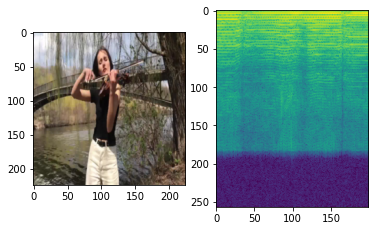

In [5]:
imsize = 224
loader_image = transforms.Compose([transforms.Resize((imsize,imsize)), transforms.ToTensor()])
#loader_spectrogram = transforms.Compose([transforms.ToTensor()])

def image_loader(image_path, audio_path):

    frame = Image.open(image_path)


    rate, sample = wavfile.read(audio_path)
    
    if sample.shape[1] == 2:
        sample = np.mean(sample,axis=1)

    middle_sample = len(sample)//2
    cur_sample = sample[middle_sample-24000:middle_sample+24000]
    fr, time, spectrogram = signal.spectrogram(cur_sample,fs=48000.,nperseg=480,noverlap=240,nfft=512)

    spectrogram = np.expand_dims(10 * np.log10(spectrogram + 1e-7), 0)
    spectrogram = np.expand_dims(spectrogram, axis=0)

    image = loader_image(frame)
    spectrogram = torch.from_numpy(spectrogram).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda(), spectrogram.cuda()#assumes that you're using GPU

frames = os.listdir('/home/brayan/Documentos/objects-that-sound-pk/material/frames')

middle_frame = frames[len(frames)//2]
image, spectrogram = image_loader('material/frames/{}'.format(middle_frame),'material/audio/danceMacabre.wav')

frame = image.permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:]

plt.subplot(1,2,1)
plt.imshow(frame)
plt.subplot(1,2,2)
plt.imshow(spectrogram.detach().cpu().numpy()[0,0,:,:])

In [6]:
out_pred, localization = model(image,spectrogram)
print(localization.shape)
print('Prediction is:', out_pred)

torch.Size([1, 1, 14, 14])
Prediction is: tensor(1., device='cuda:0', grad_fn=<SqueezeBackward0>)


In [7]:
print(type(frame[0,0,0]), frame[0,0,0])

<class 'numpy.float32'> 0.8509804


In [8]:
def overlay(img, data):
    # convert heatmap data into ndarray
    data = np.asarray(data) * 255
    data = np.array(data, dtype=np.uint8)
    img = img * 255
    img = img.astype('uint8')
    # convert heatmap according to cv2.COLORMAP_HOT
    # reference link: https://docs.opencv.org/2.4/modules/contrib/doc/facerec/colormaps.html
    heatmap = cv2.applyColorMap(data, cv2.COLORMAP_HOT)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # resize heatmap to be same with img
    heatmapx16 = cv2.resize(heatmap, None, fx=16, fy=16, interpolation=cv2.INTER_AREA)

    # overlay img and heatmap
    dst = cv2.addWeighted(img, 0.5, heatmapx16, 0.5, 0)

    return dst, img

In [9]:
dst, frame = overlay(frame, localization.detach().cpu().numpy()[0,0,:,:])

(-0.5, 223.5, 223.5, -0.5)

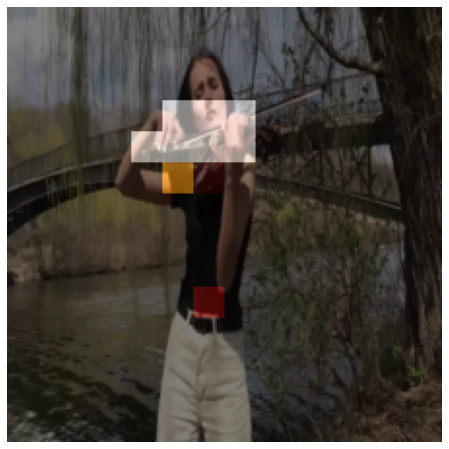

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(dst)
plt.axis('off')